In [5]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [6]:
from pprint import pprint
import numpy as np
import tensorflow as tf

# tf.enable_v2_behavior()
import tensorflow_probability as tfp

In [7]:
tfd = tfp.distributions

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Case 2 - Aleatoric (statistical) Uncertainty: / Known Unknowns

In [9]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """

    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [10]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [53]:
def run_refit(model, x, y, epochs, learning_rate):
    callbacks = [PrintDot()]
    model.fit(x, y, epochs=epochs, verbose=False, callbacks=callbacks)

    return model

In [196]:
def run_case2_tfp_ann(x, y, epochs, learning_rate):
    callbacks = [PrintDot()]
    

    #     activation = 'relu'
    activation = tf.keras.layers.LeakyReLU(alpha=0.3)

    model = tf.keras.Sequential(
        [
            # Here we have added another Neuron so we have TWO free parameters.
            # The second one will be used to model the standard deviation
            # the first parameter is t[...,:1] and the second is t[...,1:]
            # we write it like this to generalise to high dimensions and more parameters later
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(1 + 1, activation="linear"),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3
                    + tf.math.softplus(0.05 * t[..., 1:]),  # ensure scale is positive
                )
            ),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])

    model.fit(x, y, epochs=epochs, verbose=False, callbacks=callbacks)

    return model

In [273]:
def plot(x, y, model):

    #     # instead of doing model.predict as you would normally
    #     # we instead just just call the model with the test set
    #     # which should return a tfd.Distribution object

    yhat = model(x)
    assert isinstance(yhat, tfd.Distribution)

    mean = yhat.mean()
    std = yhat.stddev()

    plt.figure(figsize=[14, 8])
    plt.scatter(x, y, label="data")

    for i, a_sample in enumerate(yhat.sample(10)):
        if i == 0:
            label = "sample"
        else:
            label = None
        plt.plot(x, a_sample, c="r", alpha=0.2, label=label)

    plt.plot(x, mean, label="mean", c="k", lw=2)

    plt.plot(x, mean - 2 * std, label="mean + 2 sigma", c="g", lw=2)
    plt.plot(x, mean + 2 * std, label="mean - 2 sigma", c="g", lw=2)

    plt.legend()
    plt.title("neural network with Gaussian output and modelled stdev")
    plt.xlabel("x")
    plt.xlabel("y")

    #     plt.xlim(-10,10)
    #     plt.ylim(-100, 100)

    plt.show()
    plt.close()
    
    
    # residuals
    
    res = np.abs(mean[:,0] - y)
    max_res_idx = np.argmax(res)
    max_res_x = x[:,0][max_res_idx]
    print(f"highest residual X = {max_res_x}")
    
    plt.figure()
    plt.plot(x, res)
    plt.title('residuals')
    plt.show()
    plt.close()
    
    return max_res_x

# try some other data

In [274]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scrinet.fits import scale

In [275]:
def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew[..., np.newaxis], iy(Xnew)

In [276]:
def scale_data(X, y):
    scaleX = True
    scaleY = True
    if scaleX:
        X = X.copy()
        X_scalers = scale.make_scalers(X)
        X = scale.apply_scaler(X, X_scalers)
    if scaleY:
        y = y.copy()
        Y_scalers = scale.make_scalers(y)
        y = scale.apply_scaler(y, Y_scalers)

    y = y[:, 0]

    return X, y

In [277]:
Xy = np.loadtxt("../../nn-fitting/1d-fitting/data_to_fit.txt")
X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T


mask = (X_raw > 0.2) &(X_raw < 0.6)
X_raw = X_raw[mask]
y_raw = y_raw[mask]


X_sc, y_sc = scale_data(X_raw.reshape(-1, 1), y_raw.reshape(-1, 1))

Text(0.5, 1.0, 'raw data')

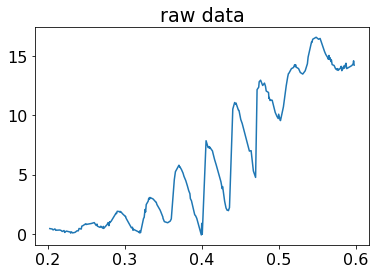

In [278]:
plt.figure()
plt.plot(X_raw, y_raw)
plt.title("raw data")

Text(0.5, 1.0, 'scaled data')

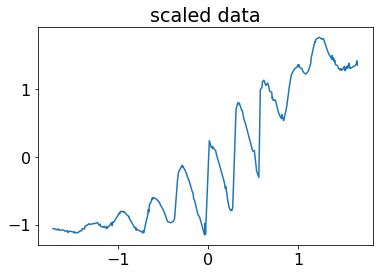

In [279]:
plt.figure()
plt.plot(X_sc, y_sc)
plt.title("scaled data")

In [280]:
# step 1
# build interpolant of data

# iy = IUS(X_sc, y_sc)

# step 2
# sample data to smaller set so it fits faster
X_step2, y_step2 = resample_data(X_sc[:,0], y_sc, xmin=None, xmax=None, npts=500, k=1)

In [281]:
np.min(X_step2)

-1.7241299839143154

In [282]:
np.max(X_step2)

1.656394489523893

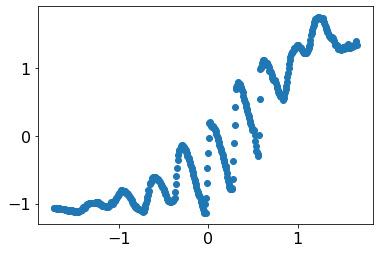

In [283]:
plt.figure()
plt.scatter(X_step2, y_step2)

In [284]:
model = run_case2_tfp_ann(X_step2, y_step2, epochs=100, learning_rate=1e-3)


....................................................................................................

In [285]:
model = run_refit(model, X_step2, y_step2, epochs=1000, learning_rate=1e-4)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



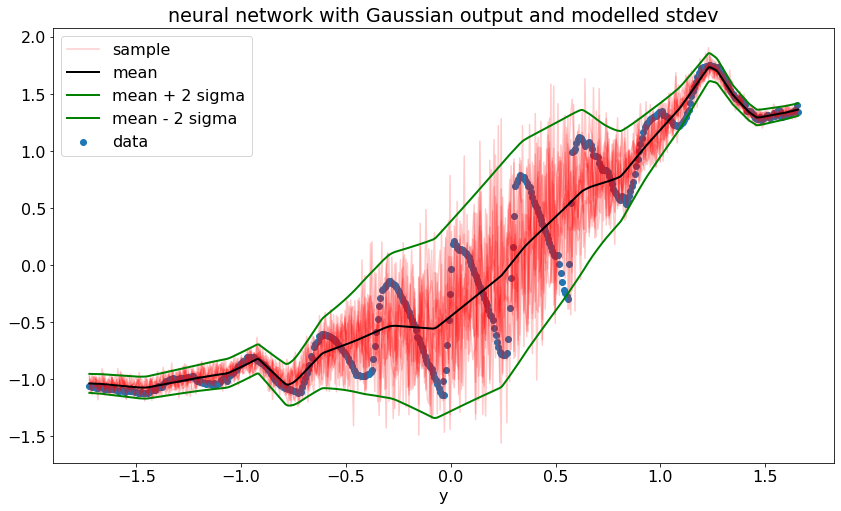

highest residual X = 0.5589095903315284


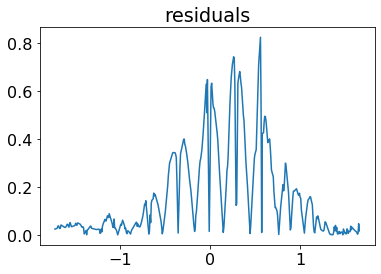

In [286]:
seed_worst_point = plot(X_step2, y_step2, model)

In [287]:
Xdata = X_step2[:,0]
ydata = y_step2
xmin_overall = Xdata[0]
xmax_overall = Xdata[-1]


X_sc_high_res, y_sc_high_res = resample_data(X_sc[:,0], y_sc, xmin=xmin_overall, xmax=xmax_overall, npts=10000, k=1)

working 0
0.45890959033152845 0.6589095903315284
(340, 1)
(340,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

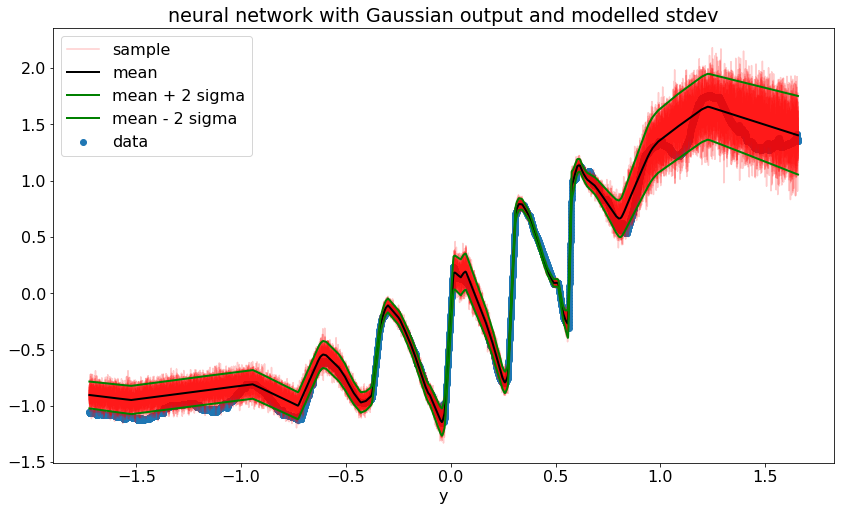

highest residual X = 1.0853668031915458


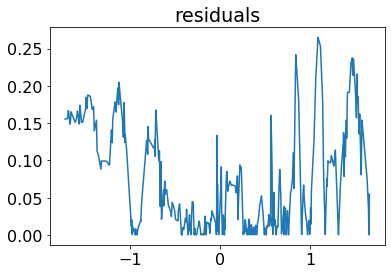

working 1
0.9853668031915458 1.1853668031915459
(440, 1)
(440,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

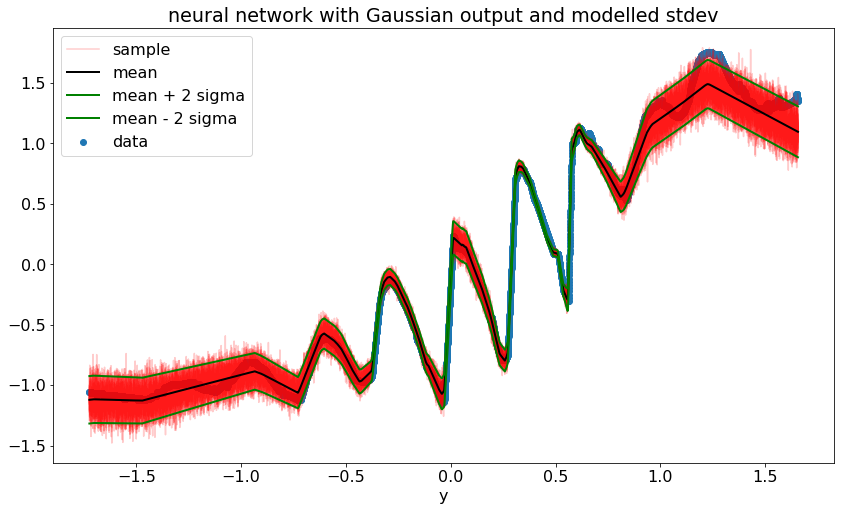

highest residual X = 1.6499708506604733


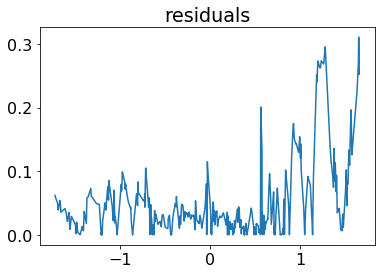

working 2
1.5499708506604732 1.656394489523893
(540, 1)
(540,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

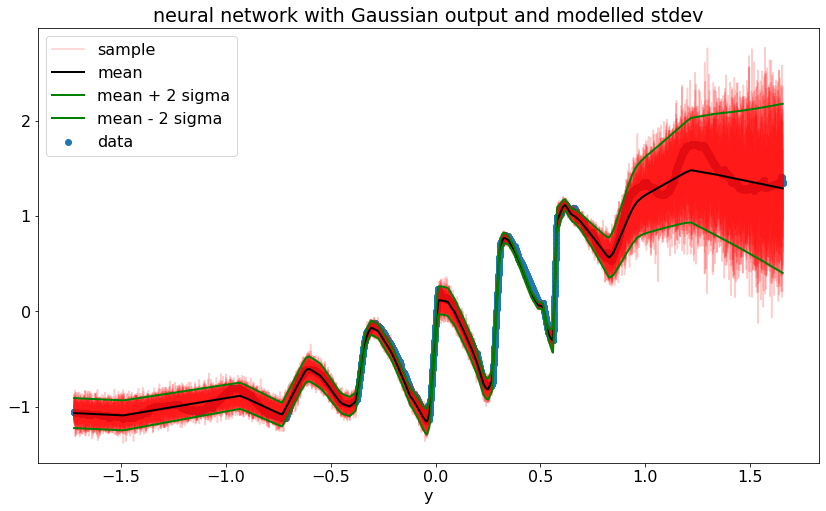

highest residual X = 1.23412475581809


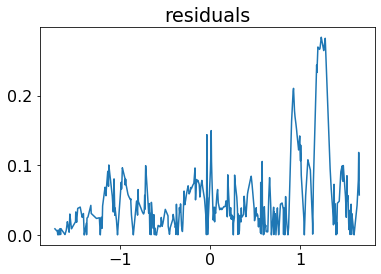

working 3
1.1341247558180898 1.33412475581809
(640, 1)
(640,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

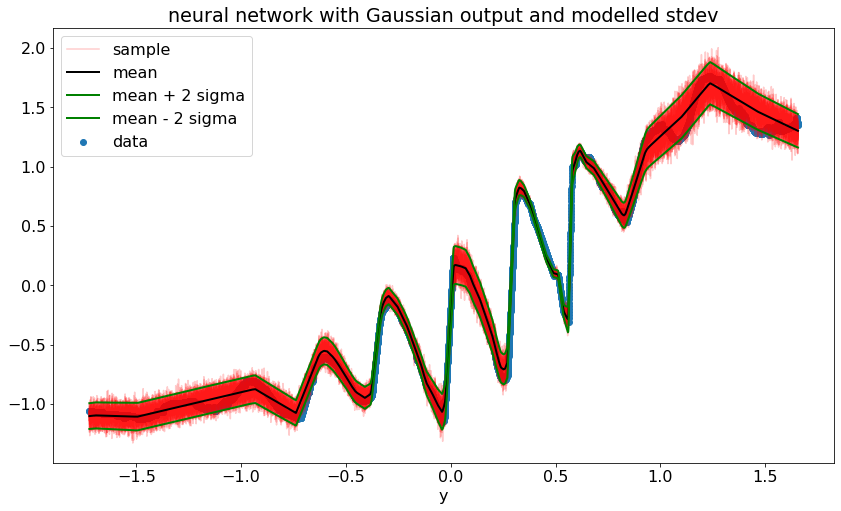

highest residual X = 1.4657138411571409


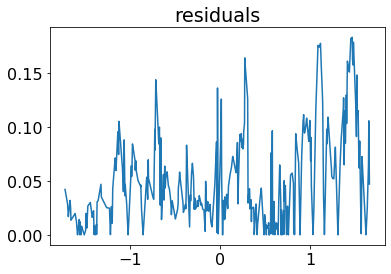

working 4
1.3657138411571408 1.565713841157141
(740, 1)
(740,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

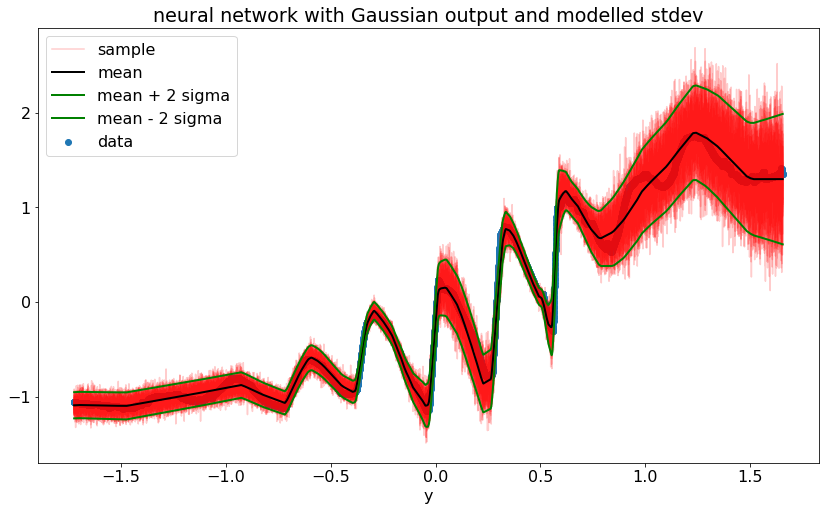

highest residual X = 0.30844458697382393


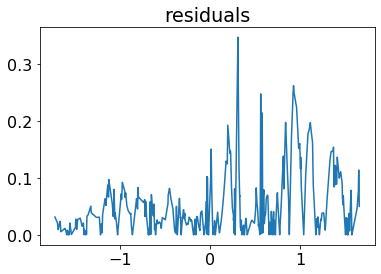

working 5
0.20844458697382393 0.4084445869738239
(840, 1)
(840,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

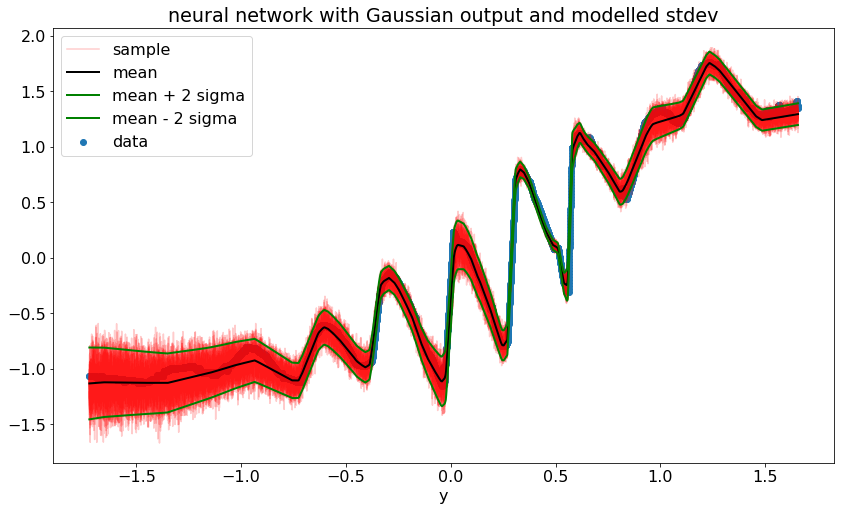

highest residual X = 0.01160485423267521


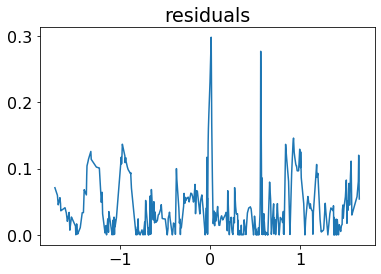

working 6
-0.0883951457673248 0.11160485423267522
(940, 1)
(940,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

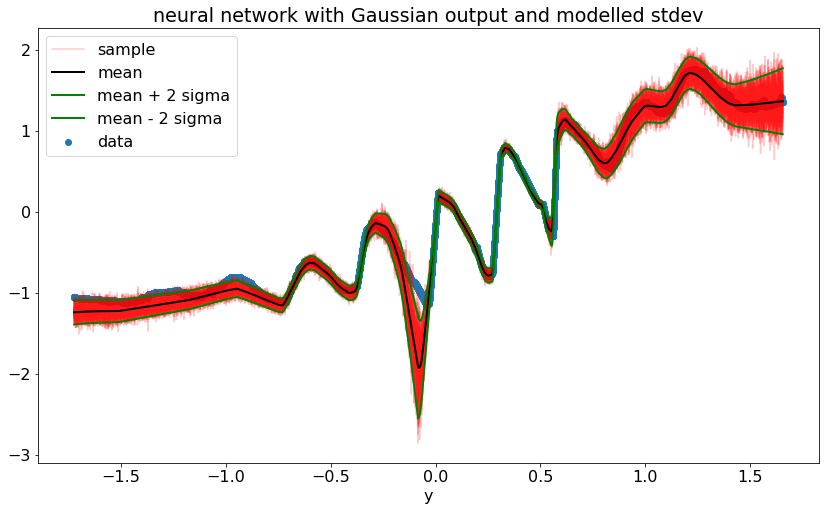

highest residual X = -0.08272121118279241


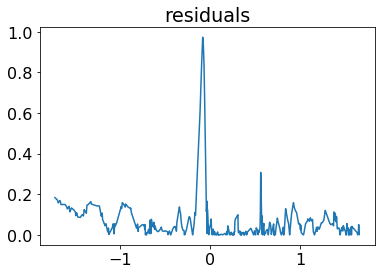

working 7
-0.18272121118279241 0.017278788817207597
(1040, 1)
(1040,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

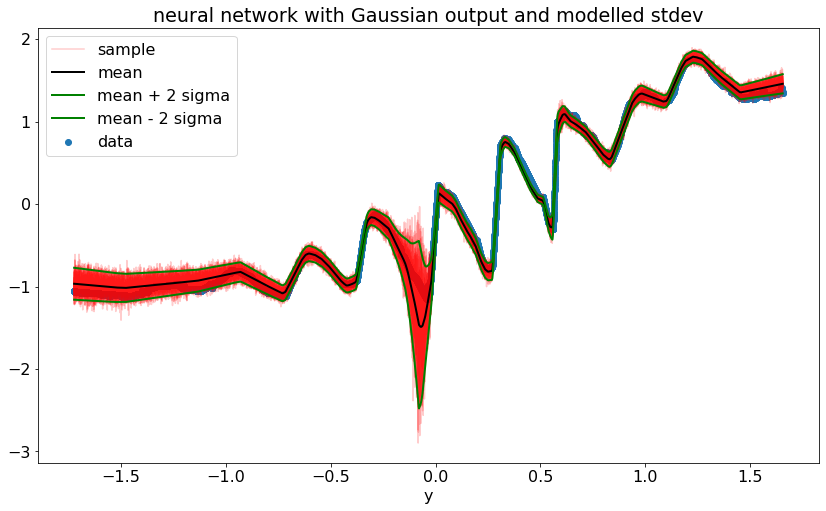

highest residual X = -0.07934034862309813


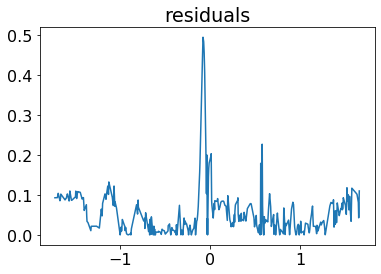

working 8
-0.17934034862309814 0.020659651376901872
(1140, 1)
(1140,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

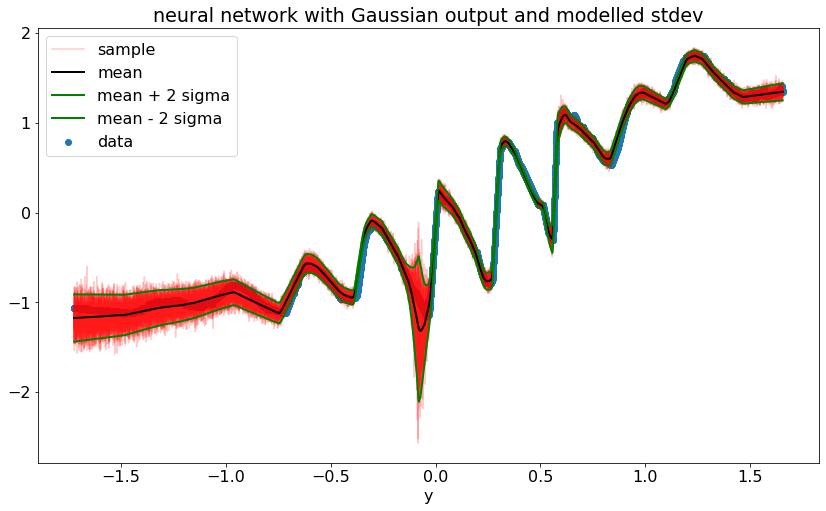

highest residual X = -0.07967843487906756


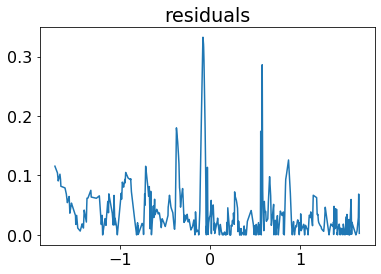

working 9
-0.17967843487906757 0.020321565120932444
(1240, 1)
(1240,)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

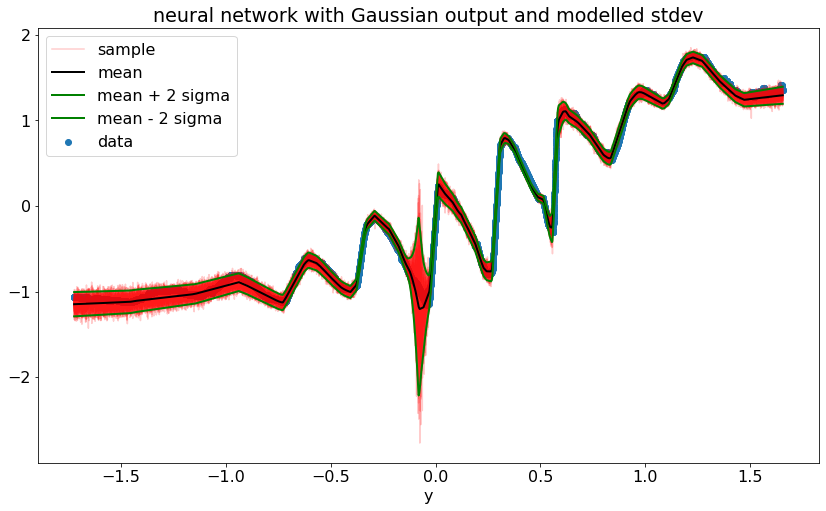

highest residual X = 0.5778993329814499


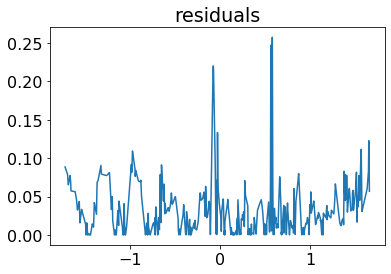

In [292]:
worst_points = []
width = 0.1

X_fit = X_sc.copy()
y_fit = y_sc.copy()

for i in range(10):
    print(f"working {i}")
    if i == 0:
        current_worst = seed_worst_point
    else:
        current_worst = worst_point
        
    # make sure we don't go out of bounds
    xmin = current_worst - width
    xmax = current_worst + width
        
    if xmin < xmin_overall:
        xmin = xmin_overall
    if xmax > xmax_overall:
        xmax = xmax_overall
        
    print(xmin, xmax)
        
    X_step_n, y_step_n = resample_data(X_sc[:,0], y_sc, xmin=xmin, xmax=xmax, npts=100, k=1)
    
    X_fit = np.concatenate([X_fit[:,0], X_step_n[:,0]])[...,np.newaxis]
    y_fit = np.concatenate([y_fit, y_step_n])
    
    print(X_fit.shape)
    print(y_fit.shape)
    
    model = run_refit(model, X_fit, y_fit, epochs=500, learning_rate=0.01)
    
    
    worst_point = plot(X_sc_high_res, y_sc_high_res, model)
    
    
    worst_points.append(worst_point)